In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from embedding import *

In [13]:
EMBED_DIM = 64
MAX_LENGTH = 100
TEST_LENGTH = 50
TEST_BATCH = 32

In [14]:
full_enc = PotentialSpinEncoding(
    EMBED_DIM,
    MAX_LENGTH,
)

In [15]:
test_potentials = torch.randn(TEST_LENGTH, TEST_BATCH)
test_spins = torch.zeros(TEST_LENGTH, TEST_BATCH)
test_spins[torch.randint(0, TEST_LENGTH, (TEST_BATCH,)), torch.arange(TEST_BATCH)] = 1

In [16]:
test_potentials

tensor([[-0.6131,  1.3820, -0.3787,  ..., -1.0998,  0.6220,  0.3294],
        [-0.3766,  0.4524, -0.5165,  ..., -0.5903,  0.4583, -1.8043],
        [ 1.1607,  0.2749,  0.0764,  ...,  0.7385, -1.4699, -0.0570],
        ...,
        [ 2.3378, -0.6581, -0.6728,  ..., -0.3249, -1.2299, -0.6035],
        [ 1.1438, -0.9660, -2.2608,  ..., -1.1322, -0.0951,  0.0197],
        [ 1.5468, -0.3937,  0.1428,  ..., -1.2777,  0.0492,  0.4348]])

In [17]:
test_spins

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
full_enc(test_potentials, test_spins).shape

torch.Size([100, 32, 64])

In [19]:
# autoregressive mask for encoder
# TODO: is the encoder mask in the right orientation?
encoder_mask = torch.triu(
    torch.ones(TEST_LENGTH * 2, TEST_LENGTH * 2) * -float("inf"), diagonal=1
)
encoder_mask

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
encoder_layer = nn.TransformerEncoderLayer(
    d_model=EMBED_DIM,
    nhead=8,
    dim_feedforward=256,
    dropout=0.1,
    activation="relu",
)

In [21]:
encoder = nn.TransformerEncoder(
    encoder_layer,
    num_layers=1,
)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [22]:
post_attn = encoder(full_enc(test_potentials, test_spins), mask=encoder_mask)
post_attn.shape

torch.Size([100, 32, 64])

In [23]:
post_attn[:, 1, :]  # logits - (seq, embed)

tensor([[-0.2351, -0.3320,  0.3114,  ...,  0.7564, -0.7638, -0.0981],
        [ 0.4418, -0.3220,  0.8262,  ...,  1.0231, -1.3270, -0.5086],
        [ 0.5077, -1.4495,  0.6560,  ...,  1.1661, -1.2613,  0.0035],
        ...,
        [-0.1703, -2.0083, -1.4974,  ...,  1.5467, -1.2134,  0.3469],
        [-1.5173, -1.6011, -2.1711,  ...,  1.4834, -1.0688,  0.6295],
        [-1.6123, -0.1485, -1.6303,  ...,  1.4366, -1.0378,  0.2579]],
       grad_fn=<SliceBackward0>)

In [24]:
prob_head = nn.Linear(EMBED_DIM, 2)
phase_head = nn.Linear(EMBED_DIM, 1)

In [25]:
prob_logits = prob_head(post_attn)
phase_logits = phase_head(post_attn)

In [26]:
prob_logits.shape, phase_logits.shape

(torch.Size([100, 32, 2]), torch.Size([100, 32, 1]))

In [27]:
TEST_BATCH

32

In [28]:
# Probabilities and phases are a function of the last sequence member?
probs = torch.softmax(prob_logits[-1, :, :], dim=-1)
phases = torch.nn.functional.softsign(phase_logits[-1, :, :]) * torch.pi

In [29]:
print(probs.shape, phases.shape)

torch.Size([32, 2]) torch.Size([32, 1])


In [30]:
probs

tensor([[0.5411, 0.4589],
        [0.5236, 0.4764],
        [0.4879, 0.5121],
        [0.4216, 0.5784],
        [0.5673, 0.4327],
        [0.5257, 0.4743],
        [0.5596, 0.4404],
        [0.5280, 0.4720],
        [0.5290, 0.4710],
        [0.5703, 0.4297],
        [0.4812, 0.5188],
        [0.5348, 0.4652],
        [0.4894, 0.5106],
        [0.4994, 0.5006],
        [0.4476, 0.5524],
        [0.4968, 0.5032],
        [0.5066, 0.4934],
        [0.4748, 0.5252],
        [0.5009, 0.4991],
        [0.5882, 0.4118],
        [0.5571, 0.4429],
        [0.4806, 0.5194],
        [0.5705, 0.4295],
        [0.5695, 0.4305],
        [0.5365, 0.4635],
        [0.5490, 0.4510],
        [0.5233, 0.4767],
        [0.5030, 0.4970],
        [0.5143, 0.4857],
        [0.5370, 0.4630],
        [0.5557, 0.4443],
        [0.5870, 0.4130]], grad_fn=<SoftmaxBackward0>)

In [31]:
spins = torch.multinomial(probs, 1).float()
spins

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])

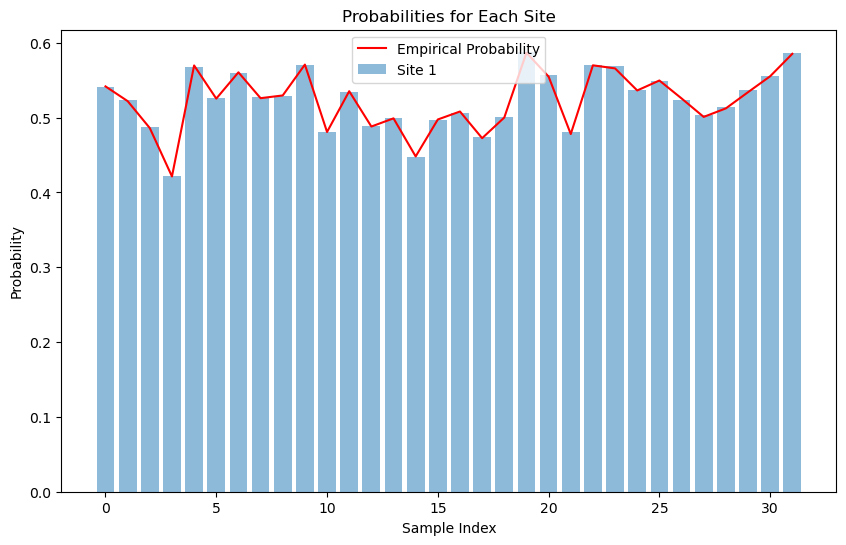

In [32]:
import matplotlib.pyplot as plt

# Convert probs tensor to numpy array for easier plotting
probs_np = probs.detach().numpy()

# Plot the probabilities for each site
plt.figure(figsize=(10, 6))
for i in range(probs_np.shape[1]):
    plt.bar(range(probs_np.shape[0]), probs_np[:, i], alpha=0.5, label=f"Site {i+1}")
    break

N = 100000
samples = torch.multinomial(probs, N, replacement=True)

# Calculate empirical probabilities
empirical_probs = 1 - samples.float().mean(dim=1).numpy()

# Overlay empirical probabilities
plt.plot(
    range(empirical_probs.shape[0]),
    empirical_probs,
    "r-",
    label="Empirical Probability",
)

plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.title("Probabilities for Each Site")
plt.legend()
plt.show()

In [33]:
phases

tensor([[ 0.1815],
        [ 0.3143],
        [-0.3151],
        [-0.3537],
        [-0.2055],
        [ 0.0680],
        [-0.2221],
        [-0.4828],
        [-0.2789],
        [-0.1994],
        [-0.0291],
        [-0.1636],
        [ 0.3139],
        [-0.2662],
        [-0.3019],
        [ 0.3577],
        [-0.2907],
        [-0.1200],
        [-0.2406],
        [-0.1376],
        [-0.0700],
        [-0.3043],
        [-0.1036],
        [-0.2453],
        [ 0.1852],
        [-0.0849],
        [ 0.0311],
        [-0.0087],
        [ 0.1738],
        [-0.2079],
        [-0.1747],
        [-0.2025]], grad_fn=<MulBackward0>)

In [34]:
def autoregressive_sampling(
    encoder, full_enc, prob_head, phase_head, test_potentials, max_length=MAX_LENGTH
):
    spins = torch.zeros(max_length, TEST_BATCH)

    # Iterate over each position in the sequence
    for i in range(max_length):
        encoded = full_enc(test_potentials, spins)

        post_attn = encoder(encoded)

        prob_logits = prob_head(post_attn)
        phase_logits = phase_head(post_attn)

        probs = torch.softmax(prob_logits[i, :, :], dim=-1)
        phases = torch.nn.functional.softsign(phase_logits[i, :, :]) * torch.pi

        spins[i, :] = torch.multinomial(probs, 1).float().squeeze()

    return spins


# Example usage
sampled_spins = autoregressive_sampling(
    encoder, full_enc, prob_head, phase_head, test_potentials
)
print(sampled_spins)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 1.]])


In [ ]:
from torch.func import jacrev

x = torch.randn(5)
jacob = jacrev(torch.sin)(x)